# Simon Algorithm
The Simon Algorithm is described in this document. The Simon Algorithm is essentially a period finding algorithm for modulo 2 arithmetic. It is much simpler than the Shor Algorithm in the sense that it does not require the use of a Quantum Fourier Transform. However, it is only applicable in the restrictive scenario of modulo 2 addition. We begin by importing the necessary qiskit libraries. We also define the number of input bits that we would like to use.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, execute
from qiskit.circuit import Gate
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.quantum_info import DensityMatrix, partial_trace
from qiskit.visualization import plot_histogram, plot_state_hinton, plot_bloch_multivector

In [2]:
# Define circuit parameters
a = '01101'
n = len(a)
m = n

## Objective
We are given a subroutine that evaluates an unknown function $f(x)$ on $n$ bit inputs and produces $m$ bit outputs. The function $f(x)$ is associated to an unknown $n$ bit constant $a$ and satisfies the property that $f(x) = f(y)$ if and only if $x \oplus y = a$. Here, $x$, $y$ and $a$ are all $n$ bit numbers, while $f(x)$ and $f(y)$ are $m$ bit numbers.

$$x \oplus y = a \implies f(x) = f(y)$$
$$x \oplus y \neq a \implies f(x) \neq f(y)$$

The function $f(x)$ is thus, a 2 to 1 function, and to ensure that the above properties are satisfiable, we must have,

$$ m \geq n-1$$

Our objective is to figure out the constant $a$ using a minimal number of subroutine calls to the function $f(x)$. Classically, the only way to do it would be to evaluate $f(x)$ for a large number of random $x$ until we get $x$, $y$ such that $f(x) = f(y)$. Then $x \oplus y = a$.

## Prerequisites
Before we describe the circuit for the Simon Algorithm, we shall need to develop a theorem that we will have the need to invoke, while describing the circuit operation. This is done in the following.

### Theorem 1
This theorem describes the action of a series of Hadamard Transforms on a series of qubits initialized to a general state $|x\rangle_n$. We claim that

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

where
1. $H^{\otimes n}$ is the $H$ operator applied individually to each of the $n$ qubits.
2. $|x\rangle_n$ is a shorthand for the $n$ bit binary representation of $x$. For example, $|3\rangle_4 = |0011\rangle$
3. $x \cdot y = x_0y_0 \oplus x_1y_1 \oplus \cdots \oplus  x_{n-1}y_{n-1}$ (Bitwise AND, then XOR of all bits)

#### Proof
$$\begin{align*}
H^{\otimes n}|x\rangle_n &= H|x_0\rangle \otimes H|x_1\rangle \otimes \cdots \otimes H|x_{n-1}\rangle \\
&= \left(\frac{|0\rangle + (-1)^{x_0}|1\rangle}{\sqrt{2}}\right) \otimes \left(\frac{|0\rangle + (-1)^{x_1}|1\rangle}{\sqrt{2}}\right) \otimes \cdots \otimes \left(\frac{|0\rangle + (-1)^{x_{n-1}}|1\rangle}{\sqrt{2}}\right) \\
&= \frac{1}{2^{n/2}}\left(\left(|0\rangle + (-1)^{x_0}|1\rangle\right) \otimes \left(|0\rangle + (-1)^{x_1}|1\rangle\right) \otimes \cdots \otimes \left(|0\rangle + (-1)^{x_{n-1}}|1\rangle\right) \right)
\end{align*}$$

Now, consider how we would multiply out the $\left(|0\rangle + (-1)^{x_i}|1\rangle\right)$ terms. We would choose either a $|0\rangle$ or a $|1\rangle$ from each of these $n$ terms and multiply (or really tensor product) with the rest of the terms to get one term of the the total expansion. The $|1\rangle$ terms come with an extra coefficient of $(-1)^{x_i}$. The final multiplied out sum will thus be the sum of all $n$ bit combinations of zeroes and ones; where each term has a $\pm 1$ coefficient. These terms are essentially all possible instances of $|y\rangle_n$. Thus, the final sum will be of the form

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} c_y |y\rangle_n$$

where each $c_y = \pm 1$. Now, we must calculate $c_y$ for a given $y$. For a fixed $y$, $c_y$ is a product of terms of the form $(-1)^{x_i}$. If the $i^{th}$ bit $y_i$, of $y$, is $0$, $(-1)^{x_i}$ would not be multiplied into $c_y$ (since $(-1)^{x_i}$ only comes in when we select a $1$ for the $i^{th}$ bit). It would be included however, if $y_i = 1$. We can account for both these cases by just multiplying $(-1)^{x_iy_i}$ into $c_y$. Therefore, considering all bits, we get,

$$c_y = (-1)^{x_0y_0}(-1)^{x_1y_1} \cdots (-1)^{x_{n-1}y_{n-1}} = (-1)^{x \cdot y}$$

Thus, we get our final result,

$$H^{\otimes n}|x\rangle_n = \frac{1}{2^{n/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x \cdot y} |y\rangle_n$$

#### Corollary
For the special case when the input qubits are all initialized to $|0\rangle$, we get,

$$H^{\otimes n}|0\rangle = \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n$$

## Circuit Description & Analysis
Next, we describe the circuit for the Simon Algorithm.

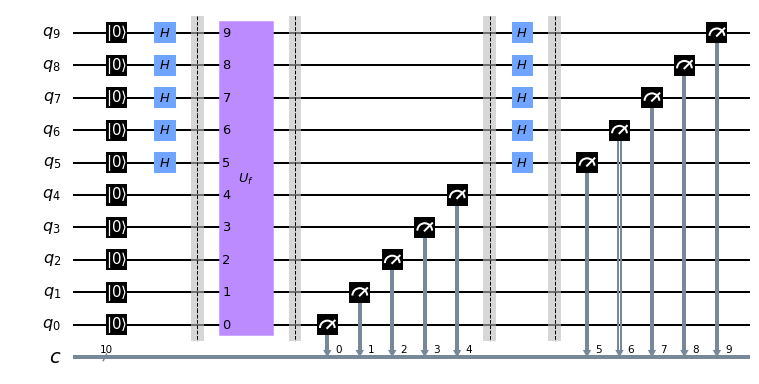

In [3]:
circ = QuantumCircuit(m+n, m+n)
circ.reset(range(m+n))
circ.h(range(m, m+n))
circ.barrier()
circ.append(Gate(name="$U_f$", num_qubits=m+n, params=[]), range(m+n))
circ.barrier()
circ.measure(range(m), range(m))
circ.barrier()
circ.h(range(m, m+n))
circ.barrier()
circ.measure(range(m, m+n), range(m, m+n))
circ.draw('mpl', reverse_bits=True, scale=0.5)

Here, the action of the $(m+n)$ qubit unitary operator $U_f$ is given by

$$U_f|xy\rangle = |x\rangle \otimes |y \oplus f(x)\rangle$$

where $x$ is an $n$ bit number and $y$ is an $m$ bit number. In the above circuit, we have marked out 4 barriers. We shall describe the circuit operation by evaluating the quantum state of the qubits at these barriers, which we shall number 1-4 from left to right.

### Barrier 1
We initialize all qubits to zeros and apply an $H$ transform to the $n$ bit input register. By the corollary to theorem 1 above, the state of the qubits is

$$\begin{align*}
|\psi_1\rangle &= H^{\otimes n}|0\rangle_n \otimes |0\rangle_{m} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |0\rangle_{m}
\end{align*}$$

### Barrier 2
We apply the Unitary gate $U_f$ to the qubits. We get

$$\begin{align*}
|\psi_2\rangle &= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |0 \oplus f(x) \rangle_{m} \\
&= \frac{1}{2^{n/2}} \sum_{x = 0}^{2^{n}-1} |x\rangle_n \otimes |f(x) \rangle_{m} \\
\end{align*}$$

### Barrier 3
We measure the output register to get a random value for $f(x_0)$. Since there are exactly two inputs $x$ and $y$ satisfying $x \oplus y = a$ such that $f(x) = f(y) = f(x_0)$, the input register collapses to the state

$$\begin{align*}
|\psi_3\rangle_n &= \frac{1}{\sqrt{2}} |x\rangle_n + |y\rangle_n \\
&= \frac{1}{\sqrt{2}} |x_0\rangle_n + |x_0 \oplus a\rangle_n \\
\end{align*}$$

### Barrier 4
We apply a chain of Hadamard Gates to the $n$ qubit input register. From theorem 1 above, we get

$$\begin{align*}
|\psi_4\rangle_n &= \frac{1}{\sqrt{2}} H^{\otimes n}|x_0\rangle_n + H^{\otimes n}|x_0 \oplus a\rangle_n \\
&= \frac{1}{2^{(n+1)/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x_0 \cdot y}|y\rangle_n + (-1)^{(x_0 \oplus a) \cdot y}|y\rangle_n \\
&= \frac{1}{2^{(n+1)/2}} \sum_{y = 0}^{2^{n}-1} (-1)^{x_0 \cdot y}(1 + (-1)^{a \cdot y})|y\rangle_n \\
&= \frac{1}{2^{(n-1)/2}} \sum_{a \cdot y = 0} (-1)^{x_0 \cdot y}|y\rangle_n \\
\end{align*}$$

### Measurement & Post Processing
We shall then measure the $n$ qubit input register. In doing so, we obtain a result $y$ satisfying $a \cdot y = 0$. This equation gives us a relation in the $n$ bits of $a$. We can solve for $a$ if we have $n$ such linearly independent equations. We thus, run the circuit multiple times to get multiple $y$ satisfying $a \cdot y = 0$, and then solve for $a$.

## Qiskit Implementation
We will now implement the unitary operator $U_f$ required in the circuit. To do this, we shall take $f(x)$ to be the following function:

$$f(x) = min(x, x \oplus a)$$

It is easily verified that the function $f(x)$ satisfies the necessary properties for the Simon Algorithm. The implementation of this function using CNOT gates is discussed in the following section.

### Oracle circuit
Let us take the following specific example.

$$\begin{align}
x &= 01101101001 \\
a &= 00011011110 \\
x \oplus a &= 01110110111
\end{align}$$

In this case, $x \lt x \oplus a$. So $f(x) = x$. In general, to figure out the minimum of $x$ and $x \oplus a$, we would look at the most significant bit at which these two numbers differ. This is essentially the most significant bit of $a$ with a $1$. In the above example, this is the $4^{th}$ most significant bit. For the general case, let this be the $i^{th}$ bit. Then,

$$f(x) = \begin{cases}
x &\; ; \; x_i = 0 \\
x \oplus a &\; ; \; x_i = 1 \\
\end{cases}$$

We thus have the following steps to implement $U_f$:
1. Copy the input register to the output register using CNOT gates: $|x\rangle \otimes |0\rangle \rightarrow |x\rangle \otimes |x\rangle$
2. Figure out the first bit in $a$ with a 1. Call this the $i^{th}$ bit.
3. Apply a series of CNOT gates to XOR the output register with $a$ conditioned on the $i^{th}$ bit of the input register.

Note that in step 1, we copy only computational basis states. We are thus, not in violation of the no-cloning theorem.

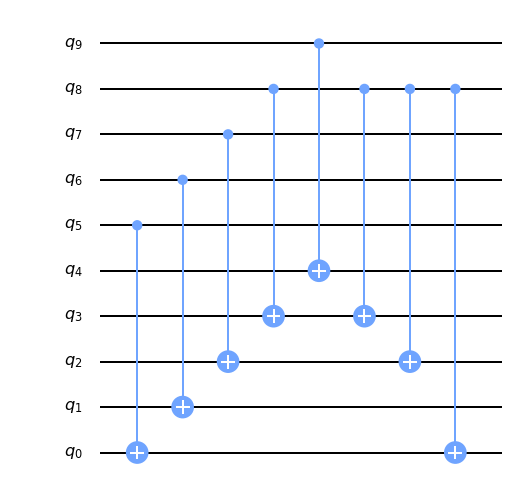

In [4]:
# Step 1
f = QuantumCircuit(m+n, name='f(x)')
f.cx(range(m, m+n), range(m))

# Step 2
index = 0
for i in range(n):
    if a[i] == '1':
        index = i
        break

# Step 3
for i in range(n):
    if a[i] == '1':
        f.cx(m+n-1-index, m-1-i)
f.draw('mpl', reverse_bits=True)

## State Vector Simulation
We simulate the Simon Algorithm using the state vector simulator. We plot the hinton diagram for the input register state at barrier 3. As expected, the state of input register at barrier 3 contains only 4 non zero values corresponding to a superposition of two states. We verify that these states XOR to $a$.

In [5]:
circ = QuantumCircuit(m+n, m+n)
circ.reset(range(m+n))
circ.h(range(m, m+n))
circ.barrier()
circ.append(f.to_instruction(), range(m+n))
circ.barrier()
circ.measure(range(m), range(m))
circ.barrier()
circ.draw(reverse_bits=True)

┌───┐ ░ ┌───────┐ ░                 ░ 
q_9: ─|0>─┤ H ├─░─┤9      ├─░─────────────────░─
          ├───┤ ░ │       │ ░                 ░ 
q_8: ─|0>─┤ H ├─░─┤8      ├─░─────────────────░─
          ├───┤ ░ │       │ ░                 ░ 
q_7: ─|0>─┤ H ├─░─┤7      ├─░─────────────────░─
          ├───┤ ░ │       │ ░                 ░ 
q_6: ─|0>─┤ H ├─░─┤6      ├─░─────────────────░─
          ├───┤ ░ │       │ ░                 ░ 
q_5: ─|0>─┤ H ├─░─┤5      ├─░─────────────────░─
          └───┘ ░ │  f(x) │ ░             ┌─┐ ░ 
q_4: ─|0>───────░─┤4      ├─░─────────────┤M├─░─
                ░ │       │ ░          ┌─┐└╥┘ ░ 
q_3: ─|0>───────░─┤3      ├─░──────────┤M├─╫──░─
                ░ │       │ ░       ┌─┐└╥┘ ║  ░ 
q_2: ─|0>───────░─┤2      ├─░───────┤M├─╫──╫──░─
                ░ │       │ ░    ┌─┐└╥┘ ║  ║  ░ 
q_1: ─|0>───────░─┤1      ├─░────┤M├─╫──╫──╫──░─
                ░ │       │ ░ ┌─┐└╥┘ ║  ║  ║  ░ 
q_0: ─|0>───────░─┤0      ├─░─┤M├─╫──╫──╫──╫──░─
                ░ └───────┘ ░ └╥┘ ║  ║  ║  ║  ░ 
c_9: ══════════════════════════╬══╬══╬══╬══╬════
                               ║  ║  ║  ║  ║    
c_8: ══════════════════════════╬══╬══╬══╬══╬════
                               ║  ║  ║  ║  ║    
c_7: ══════════════════════════╬══╬══╬══╬══╬════
                               ║  ║  ║  ║  ║    
c_6: ══════════════════════════╬══╬══╬══╬══╬════
                               ║  ║  ║  ║  ║    
c_5: ══════════════════════════╬══╬══╬══╬══╬════
                               ║  ║  ║  ║  ║    
c_4: ══════════════════════════╬══╬══╬══╬══╩════
                               ║  ║  ║  ║       
c_3: ══════════════════════════╬══╬══╬══╩═══════
                               ║  ║  ║          
c_2: ══════════════════════════╬══╬══╩══════════
                               ║  ║             
c_1: ══════════════════════════╬══╩═════════════
                               ║                
c_0: ══════════════════════════╩════════════════

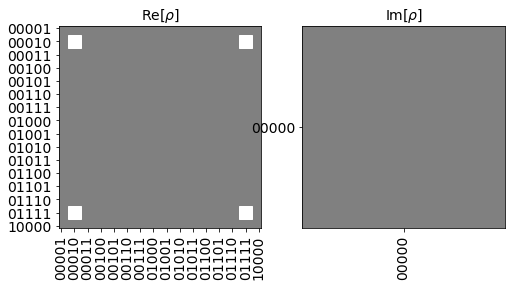

In [6]:
simulator = Aer.get_backend('statevector_simulator')
result = execute(circ, simulator).result()
state = result.get_statevector()
state = get_subsystem_density_matrix(state, range(m))
plot_state_hinton(state)

We can also use the bloch vectors of the input register to verify that the states XOR to $a$. For the qubits with corresponding bit $a_i = 0$, we expect the $i^{th}$ bit of $x_0$ to be the same as the $i^{th}$ bit of $x_0 \oplus a$, so the bloch vector should be along the $z$ axis for these qubits ($|0\rangle$ or $|1\rangle$). For the qubits with corresponding bit $a_i = 1$, we expect the $i^{th}$ bit of $x_0$ to be the opposite of the $i^{th}$ bit of $x_0 \oplus a$, so the bloch vector should be $0$ for these qubits as they are in the maximally entangled state. This is shown below.

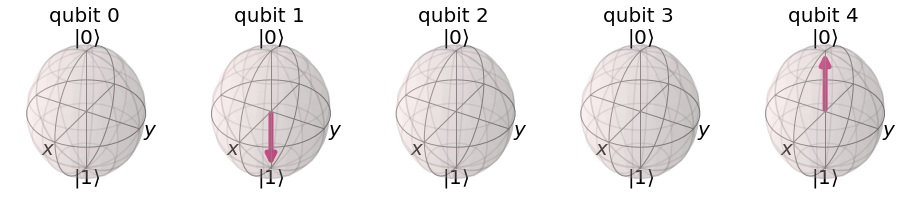

In [7]:
plot_bloch_multivector(state)

## QASM Simulation
Now, we complete the circuit for the Simon Algortihm and run a full QASM simulation.

In [8]:
circ.h(range(m, m+n))
circ.barrier()
circ.measure(range(m, m+n), range(m, m+n))
circ.draw(reverse_bits=True)

┌───┐ ░ ┌───────┐ ░                 ░ ┌───┐ ░             ┌─┐
q_9: ─|0>─┤ H ├─░─┤9      ├─░─────────────────░─┤ H ├─░─────────────┤M├
          ├───┤ ░ │       │ ░                 ░ ├───┤ ░          ┌─┐└╥┘
q_8: ─|0>─┤ H ├─░─┤8      ├─░─────────────────░─┤ H ├─░──────────┤M├─╫─
          ├───┤ ░ │       │ ░                 ░ ├───┤ ░       ┌─┐└╥┘ ║ 
q_7: ─|0>─┤ H ├─░─┤7      ├─░─────────────────░─┤ H ├─░───────┤M├─╫──╫─
          ├───┤ ░ │       │ ░                 ░ ├───┤ ░    ┌─┐└╥┘ ║  ║ 
q_6: ─|0>─┤ H ├─░─┤6      ├─░─────────────────░─┤ H ├─░────┤M├─╫──╫──╫─
          ├───┤ ░ │       │ ░                 ░ ├───┤ ░ ┌─┐└╥┘ ║  ║  ║ 
q_5: ─|0>─┤ H ├─░─┤5      ├─░─────────────────░─┤ H ├─░─┤M├─╫──╫──╫──╫─
          └───┘ ░ │  f(x) │ ░             ┌─┐ ░ └───┘ ░ └╥┘ ║  ║  ║  ║ 
q_4: ─|0>───────░─┤4      ├─░─────────────┤M├─░───────░──╫──╫──╫──╫──╫─
                ░ │       │ ░          ┌─┐└╥┘ ░       ░  ║  ║  ║  ║  ║ 
q_3: ─|0>───────░─┤3      ├─░──────────┤M├─╫──░───────░──╫──╫──╫──╫──╫─
                ░ │       │ ░       ┌─┐└╥┘ ║  ░       ░  ║  ║  ║  ║  ║ 
q_2: ─|0>───────░─┤2      ├─░───────┤M├─╫──╫──░───────░──╫──╫──╫──╫──╫─
                ░ │       │ ░    ┌─┐└╥┘ ║  ║  ░       ░  ║  ║  ║  ║  ║ 
q_1: ─|0>───────░─┤1      ├─░────┤M├─╫──╫──╫──░───────░──╫──╫──╫──╫──╫─
                ░ │       │ ░ ┌─┐└╥┘ ║  ║  ║  ░       ░  ║  ║  ║  ║  ║ 
q_0: ─|0>───────░─┤0      ├─░─┤M├─╫──╫──╫──╫──░───────░──╫──╫──╫──╫──╫─
                ░ └───────┘ ░ └╥┘ ║  ║  ║  ║  ░       ░  ║  ║  ║  ║  ║ 
c_9: ══════════════════════════╬══╬══╬══╬══╬═════════════╬══╬══╬══╬══╩═
                               ║  ║  ║  ║  ║             ║  ║  ║  ║    
c_8: ══════════════════════════╬══╬══╬══╬══╬═════════════╬══╬══╬══╩════
                               ║  ║  ║  ║  ║             ║  ║  ║       
c_7: ══════════════════════════╬══╬══╬══╬══╬═════════════╬══╬══╩═══════
                               ║  ║  ║  ║  ║             ║  ║          
c_6: ══════════════════════════╬══╬══╬══╬══╬═════════════╬══╩══════════
                               ║  ║  ║  ║  ║             ║             
c_5: ══════════════════════════╬══╬══╬══╬══╬═════════════╩═════════════
                               ║  ║  ║  ║  ║                           
c_4: ══════════════════════════╬══╬══╬══╬══╩═══════════════════════════
                               ║  ║  ║  ║                              
c_3: ══════════════════════════╬══╬══╬══╩══════════════════════════════
                               ║  ║  ║                                 
c_2: ══════════════════════════╬══╬══╩═════════════════════════════════
                               ║  ║                                    
c_1: ══════════════════════════╬══╩════════════════════════════════════
                               ║                                       
c_0: ══════════════════════════╩═══════════════════════════════════════

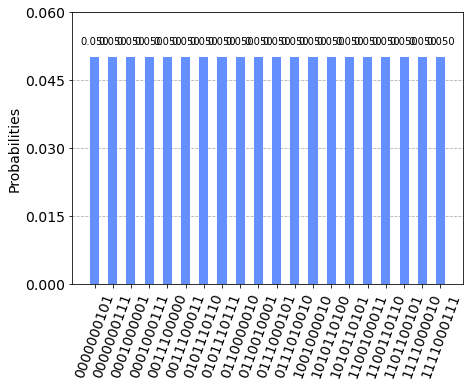

In [9]:
delta = 15
simulator = Aer.get_backend('qasm_simulator')
result = execute(circ, simulator, shots=n+delta).result()
counts = result.get_counts(circ)
plot_histogram(counts)

In [ ]:
y = [bitstr[0:n] for bitstr in counts.keys()]
print(y)

['00111', '01011', '10010', '11001', '10101', '11110', '01100', '00010', '01100', '11011', '00111', '01110', '11001', '00010', '11110', '10101', '00000', '00000', '01011', '01110']


It is easily verified that for the above list $L$,

$$y \cdot a = 0 \;\forall\; y \in L$$

A standard classical linear solver such as gaussian elimination may then be used to solve for $a$.

## References
1. Simon, D. R. (1997). On the power of quantum computation. SIAM journal on computing, 26(5), 1474-1483.
2. Mermin, N. D. (2007). Quantum computer science: An introduction. Cambridge University Press.
3. Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information: 10th anniversary edition. Cambridge University Press.
4. Qiskit documentation — Qiskit 0.19.3 documentation. (n.d.). Qiskit. https://qiskit.org/documentation/